## Summary of Notebook

This notebook contains the implementation of the EfficientNetB0 model with ECA implementation. It provides the results obtained from this model and its performance across the training, validation, and testing phases.

## Set Up
Here, we will begin by downloading the necessary dataset for flowers102, followed by the creation of dataloaders and the implementation of train and test functions.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from scipy.io import loadmat
import pandas as pd
from torch.utils.data import Dataset
import json

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [3]:
train_dataset = torchvision.datasets.Flowers102("./data/train", split="train", download=True, transform=data_transforms["train"])
val_dataset = torchvision.datasets.Flowers102("./data/val", split="val", download=True, transform=data_transforms["val"])
test_dataset = torchvision.datasets.Flowers102("./data/test", split="test", download=True, transform=data_transforms["test"])

In [4]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

In [5]:
dataloaders = {}
dataloaders["train"] = train_dataloader
dataloaders["val"] = val_dataloader
dataloaders["test"] = test_dataloader

In [6]:
dataset_sizes = {}
dataset_sizes["train"] = len(train_dataloader.dataset)
dataset_sizes["val"] = len(val_dataloader.dataset)
dataset_sizes["test"] = len(test_dataloader.dataset)

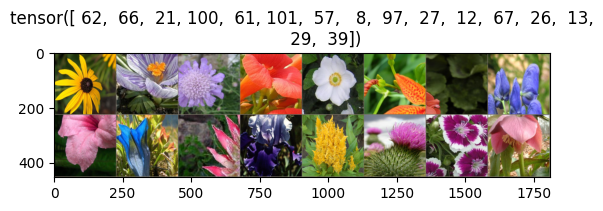

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes)



In [8]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def test_model(model, criterion):
  running_loss = 0.0
  running_corrects = 0
  for inputs, labels in dataloaders["test"]:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
  total_loss = running_loss / dataset_sizes["test"]
  total_acc = running_corrects.double() / dataset_sizes["test"]
  return total_loss, total_acc

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_accuracies = []
    val_accuracies = []

    # Detect if GPU is available and use it, otherwise fall back to CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Move the model to the correct device
    model = model.to(device)

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Training and validation phases
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                # Use your predefined dataloaders here
                data_loader = dataloaders[phase]

                for inputs, labels in data_loader:
                    # Move inputs and labels to the correct device
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the gradients
                    optimizer.zero_grad()

                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward pass + optimization if training
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels)

                # Step the scheduler if training
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / len(data_loader.dataset)
                epoch_acc = running_corrects.double() / len(data_loader.dataset)

                if phase == 'train':
                    train_accuracies.append(epoch_acc.item())
                else:
                    val_accuracies.append(epoch_acc.item())

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Deep copy the model if validation accuracy improves
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        # Load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model, train_accuracies, val_accuracies


In [11]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model_conv = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model_conv = efficientnet_b0(weights="DEFAULT")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Modify the Architecture (Replacing Squeeze-and-Excitation to Efficient Channel Attention in each MBCONV)

In this section, we will replace all the squeeze-and-excitation modules in each of the MBCONV blocks in the EfficientNetB0 with the more lightweight Efficient Channel Attention module.

In [12]:
model_a= efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model_a = efficientnet_b0(weights="DEFAULT")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
import math
class ECA(nn.Module):
    """Constructs a ECA module.


    Args:
        channels: Number of channels in the input tensor
        b: Hyper-parameter for adaptive kernel size formulation. Default: 1
        gamma: Hyper-parameter for adaptive kernel size formulation. Default: 2
    """
    def __init__(self, channels, b=1, gamma=2):
        super(ECA, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.channels = channels
        self.b = b
        self.gamma = gamma
        self.conv = nn.Conv1d(1, 1, kernel_size=self.kernel_size(), padding=(self.kernel_size() - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()


    def kernel_size(self):
        k = int(abs((math.log2(self.channels)/self.gamma)+ self.b/self.gamma))
        out = k if k % 2 else k+1
        return out


    def forward(self, x):


        # feature descriptor on the global spatial information
        y = self.avg_pool(x)


        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)


        # Multi-scale information fusion
        y = self.sigmoid(y)


        return x * y.expand_as(x)


In [14]:
# replacing each SE with ECA in MBCONV
model_a.features[1][0].block[1] = ECA(32)
model_a.features[2][0].block[2] = ECA(96)
model_a.features[2][1].block[2] = ECA(96)
model_a.features[3][0].block[2] = ECA(144)
model_a.features[3][1].block[2] = ECA(240)
model_a.features[4][0].block[2] = ECA(240)
model_a.features[4][1].block[2] = ECA(480)
model_a.features[4][2].block[2] = ECA(480)
model_a.features[5][0].block[2] = ECA(480)
model_a.features[5][1].block[2] = ECA(672)
model_a.features[5][2].block[2] = ECA(672)
model_a.features[6][0].block[2] = ECA(672)
model_a.features[6][1].block[2] = ECA(1152)
model_a.features[6][2].block[2] = ECA(1152)
model_a.features[6][3].block[2] = ECA(1152)
model_a.features[7][0].block[2] = ECA(1152)

In [15]:
model_a.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): ECA(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (sigmoid): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [16]:
num_ftrs = model_a.classifier[1].in_features


model_a.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(num_ftrs, 102),
        )


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_a = optim.SGD(model_a.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_a, step_size=7, gamma=0.1)

In [17]:
model_a, train_accuracies_a, val_accuracies_a = train_model(model_a, criterion, optimizer_a, exp_lr_scheduler, num_epochs=25)

Using device: cuda
Epoch 0/24
----------
train Loss: 4.3898 Acc: 0.0559
val Loss: 3.8265 Acc: 0.1696

Epoch 1/24
----------
train Loss: 3.2937 Acc: 0.2480
val Loss: 2.3557 Acc: 0.4029

Epoch 2/24
----------
train Loss: 2.2511 Acc: 0.4343
val Loss: 1.7455 Acc: 0.5412

Epoch 3/24
----------
train Loss: 1.5870 Acc: 0.6098
val Loss: 1.1417 Acc: 0.6941

Epoch 4/24
----------
train Loss: 1.2697 Acc: 0.6755
val Loss: 0.9497 Acc: 0.7382

Epoch 5/24
----------
train Loss: 0.9608 Acc: 0.7510
val Loss: 1.0065 Acc: 0.7461

Epoch 6/24
----------
train Loss: 0.7856 Acc: 0.8039
val Loss: 0.6472 Acc: 0.8324

Epoch 7/24
----------
train Loss: 0.6142 Acc: 0.8382
val Loss: 0.5157 Acc: 0.8559

Epoch 8/24
----------
train Loss: 0.4920 Acc: 0.8941
val Loss: 0.4788 Acc: 0.8755

Epoch 9/24
----------
train Loss: 0.4896 Acc: 0.8980
val Loss: 0.4743 Acc: 0.8794

Epoch 10/24
----------
train Loss: 0.4253 Acc: 0.9039
val Loss: 0.4485 Acc: 0.8902

Epoch 11/24
----------
train Loss: 0.3901 Acc: 0.9147
val Loss: 0.4

C:\Users\Arnav\AppData\Local\Temp\ipykernel_27060\2696570482.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


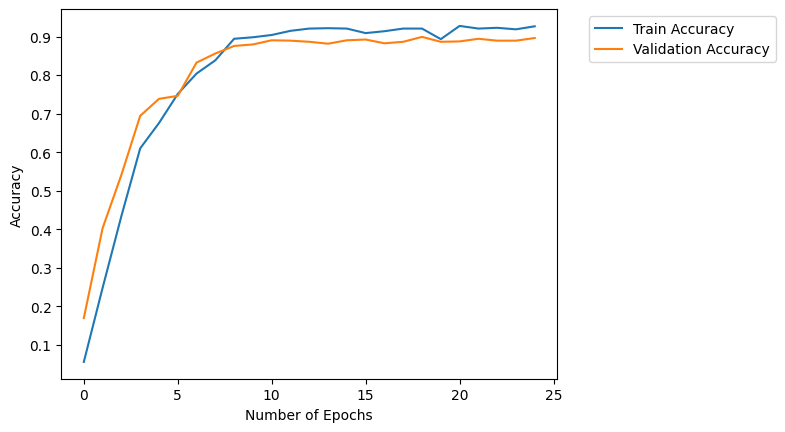

In [18]:
plt.plot(range(25), train_accuracies_a, label="Train Accuracy")
plt.plot(range(25), val_accuracies_a, label="Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.yticks(np.arange(0.1, 1, 0.1))
plt.show()

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def visualize_model(model, dataloaders, device, num_images=6):
    """
    Visualize predictions of the model on a few validation images.

    Args:
        model (torch.nn.Module): The trained model to visualize.
        dataloaders (dict): Dictionary containing training/validation dataloaders.
        device (torch.device): The device to run the model on (CPU or GPU).
        num_images (int): The number of images to display.
    """
    was_training = model.training
    model.eval()  # Set model to evaluation mode
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            # Move inputs and labels to the specified device (CPU or GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Move inputs back to CPU for visualization
            inputs = inputs.cpu()

            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {preds[j].item()} | True: {labels[j].item()}')
                imshow(inputs[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    model.train(mode=was_training)


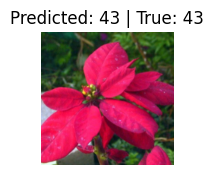

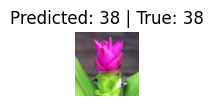

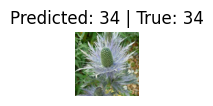

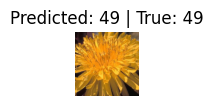

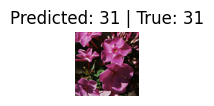

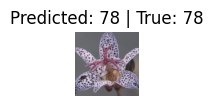

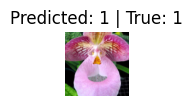

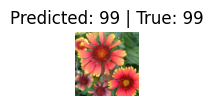

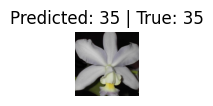

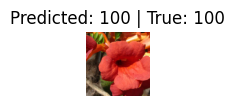

In [29]:
visualize_model(model_a, dataloaders, device, num_images=10)

### Comparison with different models

In [30]:
# test accuracies for the 3 models
criterion = nn.CrossEntropyLoss()
loss_a, accuracy_a = test_model(model_a, criterion)

In [31]:
print(f"{ 'Test Loss (ECA)'.ljust(30) } : {loss_a:.4f}")
print(f"{ 'Test Accuracy (ECA)'.ljust(30) } : {accuracy_a:.4f}")

Test Loss (ECA)                : 0.5037
Test Accuracy (ECA)            : 0.8676
